- シミュレーションの結論としては、、精度の凄く良い推定方法ではないが、大まかには合っている。
- 必ず未観測共通変数を見つけることができるということではない
- 因果構造が複雑になると結構あやふやな推定をする

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lingam
from lingam.utils import make_dot, make_prior_knowledge
import graphviz
from IPython.display import Image
import warnings 
warnings.simplefilter('ignore') #　LiNGAM学習時に出てくる警告文を消す
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore, PC, HillClimbSearch, ExhaustiveSearch, BicScore, K2Score
# ネットワークを描写するためのライブラリー
from pyvis import network as net
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def make_prior_knowledge_graph(prior_knowledge_matrix, label):
    d = graphviz.Digraph(engine='dot')

    # labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    labels = label
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

# データ生成

In [11]:
# 10この変数を作る
# size = 100
# np.random.uniform(10,size=size) # 一様分布から値を生成
# np.random.randint(0,2,size=size) #0か１のダミー変数
# np.random.normal(size=size) # 正規分布から生成
# np.random.binomial(1,0.8,size=size) #　偏った確率で１を生成する

In [3]:
size = 800

# 誤差項
e0= np.random.uniform(size=size)
e1 = np.random.uniform(size=size)
e3 = np.random.uniform(size=size)
e4 = np.random.uniform(size=size)
e5 = np.random.uniform(size=size)
e7 = np.random.uniform(size=size)

# 上流の変数を生成
x0 = np.random.randint(20,80,size=size) + e0
x1 = np.random.uniform(0,1,size=size) + 0.01*e1
x3 = np.random.binomial(1,0.2,size=size)
x5 = np.random.binomial(1,0.5,size=size)
x7 = 20 + e7

# 下流の変数
x2 = 0.1*x0 + 4*x1 + np.random.poisson(3,size=size) #　乱数はポアソン分布より生成
x4 = x5*20 + np.random.binomial(1,0.5,size=size)
x6 = x5*4 + np.random.geometric(0.01,size=size)
x8 = 5*x1 + 2*x3 + 10*x4 + np.random.geometric(0.1,size=size)
x9 = 10*x8 + np.random.geometric(0.08,size=size)

# 結果変数
x10 = 500*x0 + 25000*x6 + 5000*x8 + 900*x9 + np.random.normal(100,size=size)

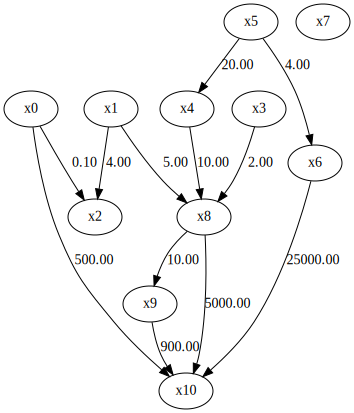

In [4]:
# データフレームに結合
tmp = ['x0','x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

m = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0.1, 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 20., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 5., 0., 2., 10., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 10, 0., 0.],
    [500., 0., 0., 0., 0., 0., 25000., 0., 5000., 900., 0.]]

dot = make_dot(m,
        labels=tmp)

# Save png
dot.format = 'png'
dot.render('correct_dag')

dot

In [18]:
# tmp = ['x0','x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
tmp = ['x0','x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'x10'] # x５を未観測共通変数とするとき

# df = pd.DataFrame([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10], index=tmp).T
df = pd.DataFrame([x0,x1,x2,x3,x4,x6,x7,x8,x9,x10], index=tmp).T # x5を潜在変数とした時
df.head()

,x0,x1,x2,x3,x4,x6,x7,x8,x9,x10
0,62.797162,0.825925,13.583416,0.0,0.0,51.0,20.860478,5.129625,56.296246,1.382813e+06
1,30.035630,0.393077,9.575871,0.0,1.0,49.0,20.792517,23.965385,252.653852,1.587333e+06
2,32.697312,0.444211,6.046575,0.0,21.0,142.0,20.282713,216.221055,2176.210548,6.606143e+06
3,50.020361,0.435389,11.743594,1.0,21.0,57.0,20.908935,215.176947,2156.769471,4.467088e+06
4,26.370728,0.069176,5.913778,1.0,21.0,56.0,20.480331,226.345881,2266.458813,4.584827e+06


In [170]:
# 相関を可視化
# color_num = 10
# df['bins_x10'] = pd.cut(df.x10, bins=color_num,labels=False)
# sns.pairplot(data=df,
#             hue='bins_x10',
#             palette=sns.color_palette("flare",n_colors=color_num),
#             )
# df = df.drop(columns='bins_x10')

# LiNGAM

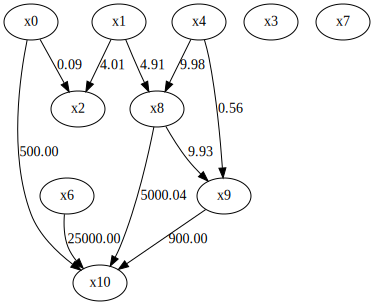

In [21]:
# カラム番号とカラム名を格納した辞書を作る
df_dict = {}
for i,j in enumerate(df):
    df_dict[j] = i

# 事前設定
prior_knowledge = make_prior_knowledge(
    n_variables=len(df_dict), # 変数の数

    # 因果の上流にあり、他から影響を受けない変数を設定する
    exogenous_variables = [],

    # 因果の最終地点にある変数を設定する
    sink_variables = [df_dict['x10']],

    # 有向パスを持つ変数。因果関係がある変数の組みを設定する。左側が元、右側が先。
    paths = [[df_dict['x3'],df_dict['x8']],[df_dict['x1'],df_dict['x8']]],

    # 有向パスのない変数。どことも関係のない変数を設定する場所。
    no_paths = [],         
)

# LiNGAMの学習
model = lingam.DirectLiNGAM(random_state=0,
                            prior_knowledge = prior_knowledge
                            )
# sc = StandardScaler()
# sc_df = sc.fit_transform(df)

model.fit(df)

# 因果ダイアグラムを図示
dot = make_dot(model.adjacency_matrix_,
        labels=df.columns.to_list(),
        )

# Save png
dot.format = 'png'
dot.render('direct_LiNGAM_dag')

dot

# BottomUpParceLiNGAM

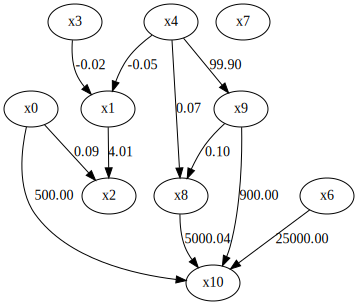

In [23]:
# 事前設定
prior_knowledge = make_prior_knowledge(
    n_variables=len(df_dict), # 変数の数

    # 因果の上流にあり、他から影響を受けない変数を設定する
    exogenous_variables = [],

    # 因果の最終地点にある変数を設定する
    sink_variables = [df_dict['x10']],

    # 有向パスを持つ変数。因果関係がある変数の組みを設定する。左側が元、右側が先。
    paths = [[df_dict['x3'],df_dict['x8']],[df_dict['x1'],df_dict['x8']]],

    # 有向パスのない変数。どことも関係のない変数を設定する場所。
    no_paths = [],         
)

model = lingam.BottomUpParceLiNGAM(random_state=0,
                                   prior_knowledge = prior_knowledge
                                    )
model.fit(df)

dot = make_dot(model.adjacency_matrix_,
              labels=df.columns.to_list())

# Save png
dot.format = 'png'
dot.render('BottomUpParceLiNGAM_dag')

dot

# CAM_UV

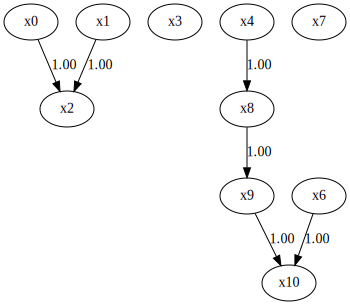

In [24]:
cam_model = lingam.CAMUV()
cam_model.fit(df)
dot = make_dot(cam_model.adjacency_matrix_,
        labels=df.columns.to_list())

# Save png
dot.format = 'png'
dot.render('CAM_UV_dag')

dot

In [11]:
print(cam_model.adjacency_matrix_)
print(df_dict.keys())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]
dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'])


# Bayesian Network

In [25]:
# 連続値データセットに対してベイジアンネットワークを活用する場合
pea_pc = PC(df)
model = pea_pc.estimate(significance_level=0.10, ci_test='pearsonr')

# 利用するあるゴアリズムを変更。変数を選択し、その隣にあるもの同士で比較するのを繰り返すアルゴ。計算量は少ない。
# model = HillClimbSearch(df).estimate(scoring_method=K2Score(df)) # 誤差の計算方法を変更

# エッジとノードを生成
edges = model.edges()
nodes = model.nodes()

edge_list = list(model.edges())
# edge_list = [i + tuple([0]) for i in edge_list] #ウェイトの値を適当に追加

#jupyter中に表示させる場合、notebook=True, →にする場合directed=True
got_net = net.Network(notebook=True,directed=True)

for e in edge_list:
    src = e[0]
    dst = e[1]
    # w = e[2]

    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, ) # 矢印にウェイトをつける場合は引数にvalue = w を追加

neighbor_map = got_net.get_adj_list()

for node in got_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
    
got_net.show_buttons(True)

got_net.show('gameofthrones2.html')

  0%|          | 0/5 [00:00<?, ?it/s]

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [23]:
# # CPDを求める
# model = BayesianModel(list(edges))
# model.add_nodes_from(list(nodes))
# for edge in edges:
#     model.add_edge(edge[0], edge[1])
# model.fit(df)
# cpds = model.get_cpds()
# for cpd in cpds:
#     print(cpd, '\n')